# Sentence-Level Financial Sentiment Analysis - Microsoft Earnings Release

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading functions

In [2]:
from extractData import ExtractData
from text_preprocessing import TextProcessor
from classifiers import classify

Extracting data from the word file

In [3]:
data = ExtractData()
df = data.extractText('/Users/yashvajani/Desktop/arp_microsoft/data/earningsrelease/')

Extracting financial data

In [4]:
data = ExtractData()
financials = data.extractFinancials('/Users/yashvajani/Desktop/arp_microsoft/data/earningsrelease/', diluted=True)
eps_df = financials[1]
fin_data = pd.read_excel('/Users/yashvajani/Desktop/arp_microsoft/data/earnings_per_share_estimates.xlsx')

Processing the extracted text

In [5]:
processer = TextProcessor()
clean_text = []
for i, text in enumerate(df['text'].to_list()):
    clean_text.append(processer.preprocess_text(text, lower=True, remove_unicode=True, lemmatize=True, remove_stops=True))
df['text_clean'] = clean_text
df = df[df['text']!='\n']
df.reset_index(inplace=True)
del df['index']

### Visualizing price data

In [6]:
import os
os.chdir('/Users/yashvajani/Desktop/arp_microsoft/data/')
colnames = ['quarter', 'time', 'change']
price_data = pd.read_csv("steffen_extract_msft.csv", names=colnames, header=None)

Calculating change across quarters

In [7]:
# Calculating overall change to get a judgement of performance of the stock following the earnings release
quarters = list(reversed(price_data['quarter'].unique()))
performance_df = pd.DataFrame()
for quarter in quarters:
    temp_df = price_data.drop('time', axis=1).set_index(['quarter']).loc[[quarter]].copy()
    temp_df['performance'] = temp_df.iloc[-1]['change'] - temp_df.iloc[0]['change']
    performance_df = pd.concat([performance_df, temp_df])
del temp_df

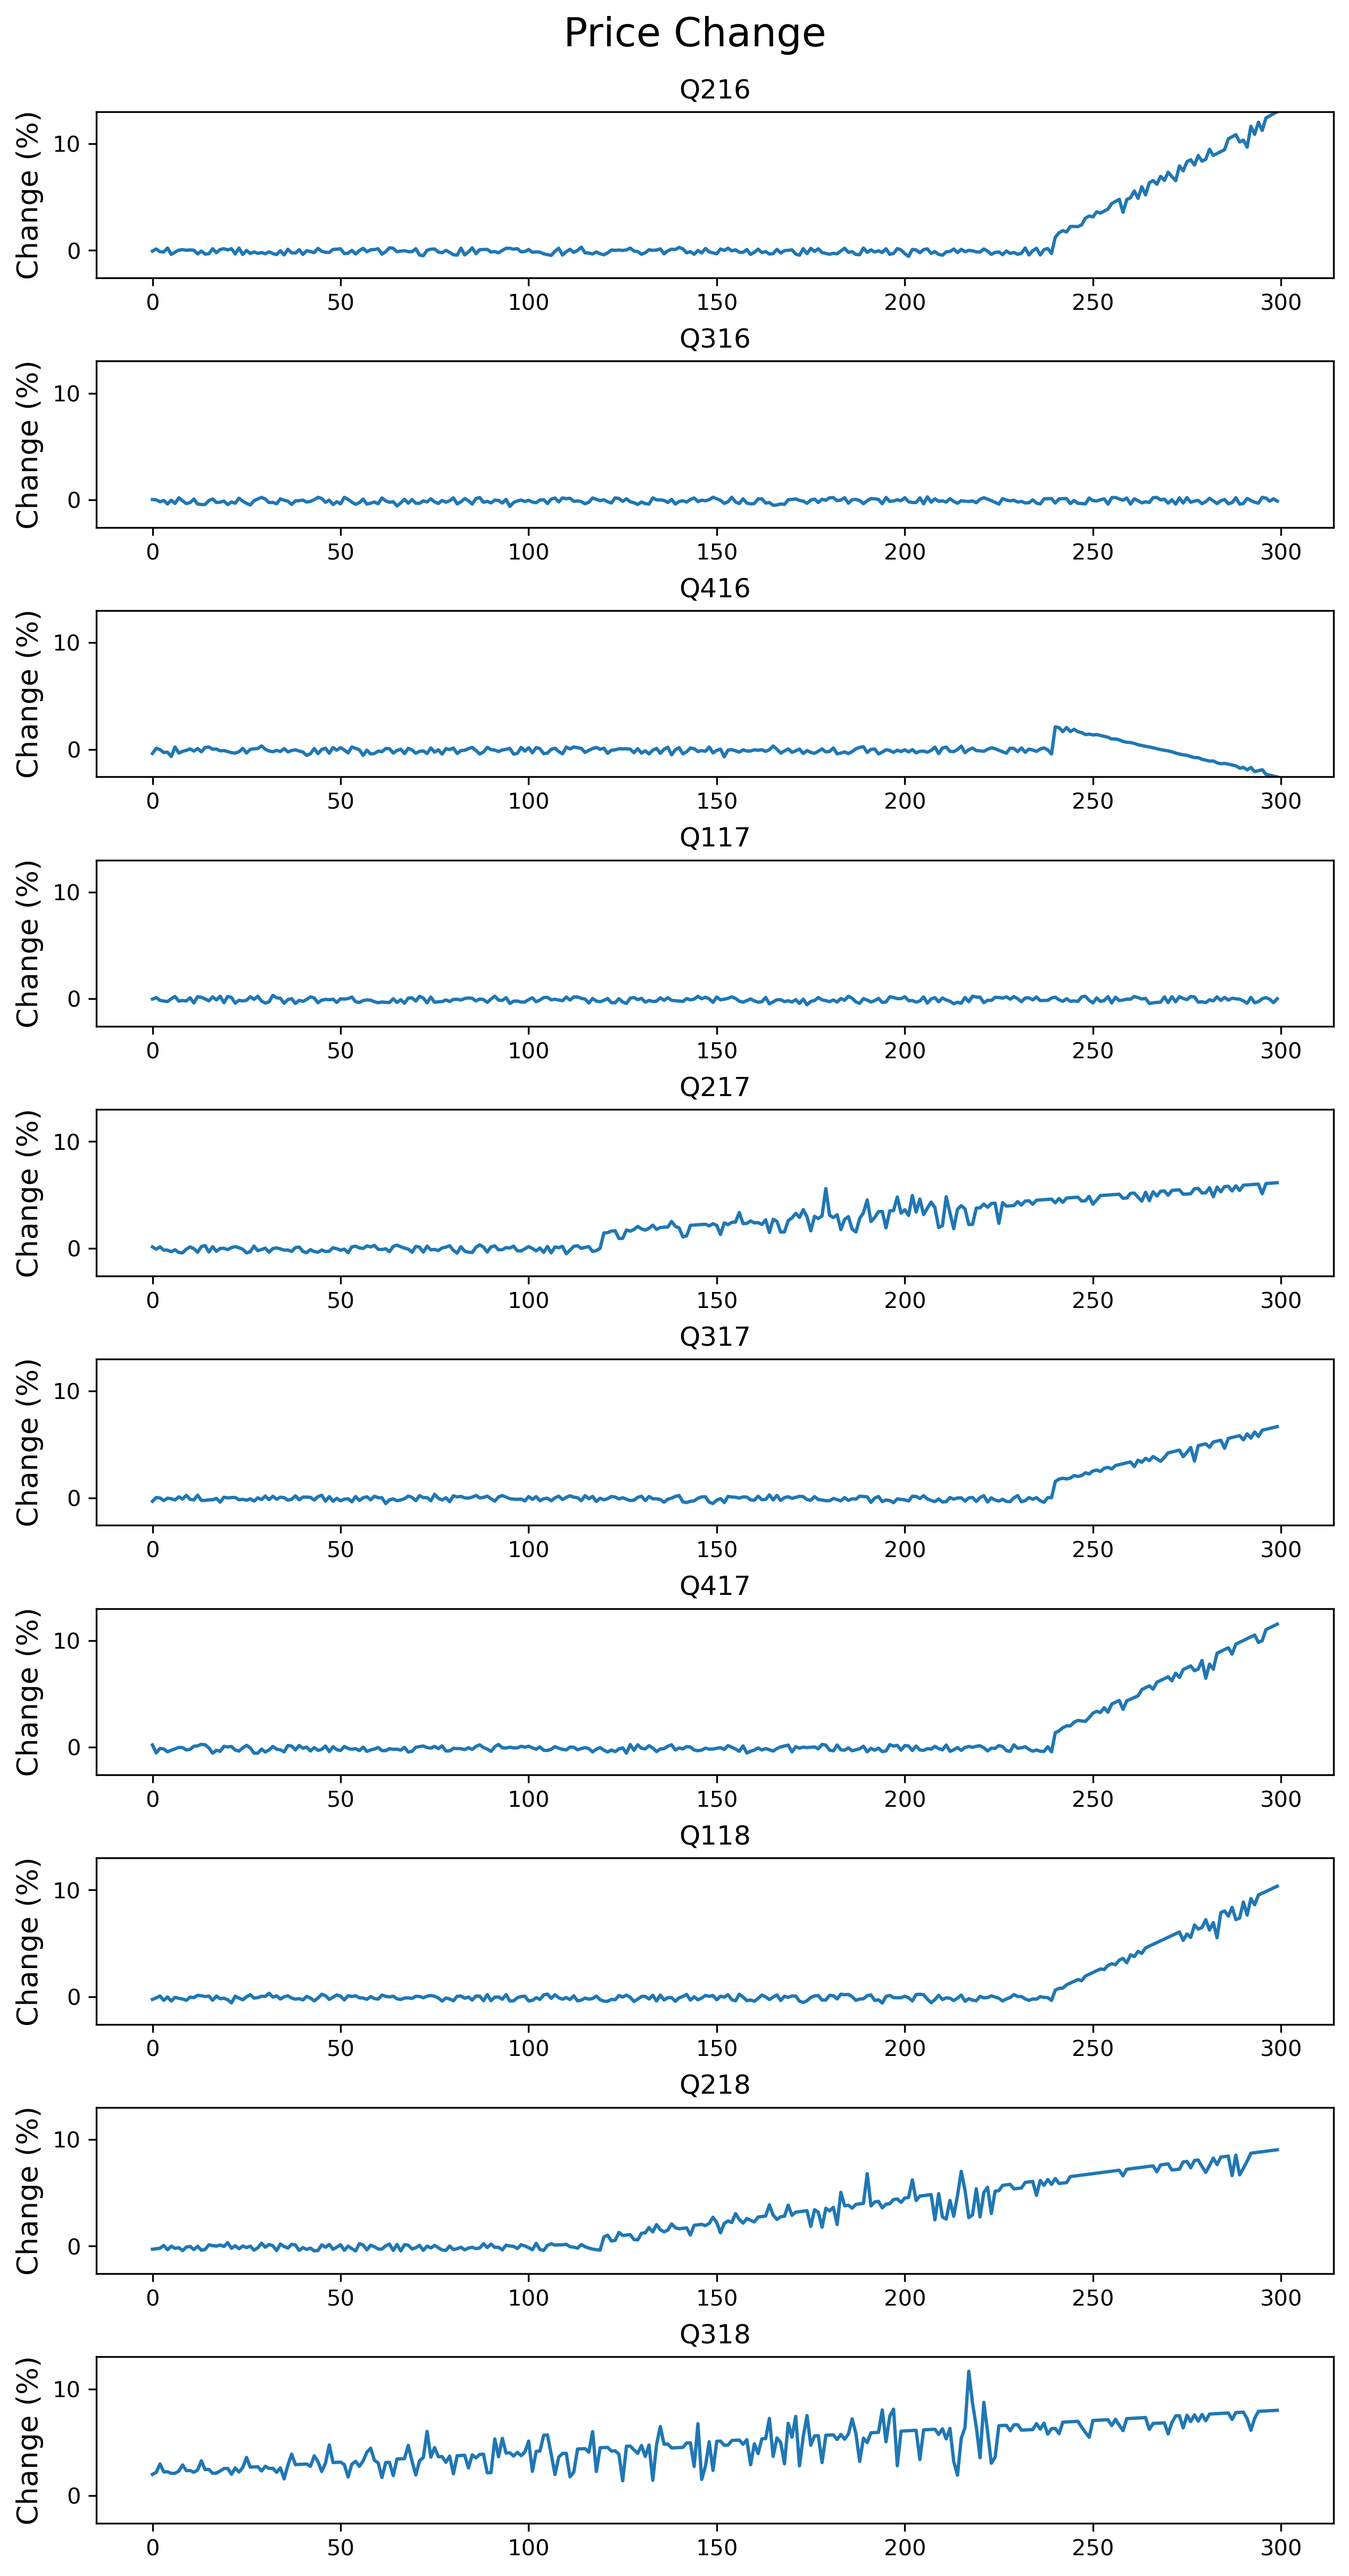

In [8]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(10, 20) , dpi=300)
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Price Change", fontsize=18, y=0.91)

for quarter, ax in zip(quarters, axs.ravel()):
    # filter df for ticker and plot on specified axes
    price_data[price_data["quarter"] == quarter].plot(y='change', x='time', ax=ax)
    # chart formatting
    ax.set_ylim([price_data['change'].min(), price_data['change'].max()])
    ax.set_xlabel('Second')
    ax.set_ylabel('Change (%)', fontdict={'size':13})
    ax.set_title(quarter.upper())
    ax.get_legend().remove()
    ax.set_xlabel("")

Calculating text metrics for EDA

In [9]:
eda_df = df.copy()
eda_df['word_count'] = eda_df['text_clean'].apply(lambda x: len(str(x).split(" ")))
eda_df['char_count'] = eda_df['text_clean'].str.len()

In [10]:
quarters = df["quarter"].unique()
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25, 15), dpi=500)
fig.suptitle("Word Count per Sentence", fontsize=20, y=0.91)
for quarter, ax in zip(quarters, axs.ravel()):
    # filter df for ticker and plot on specified axes
    eda_df[eda_df["quarter"] == quarter]['word_count'].plot(kind='box', ax=ax)
    # chart formatting
    ax.set_ylim([eda_df['word_count'].min()-1, eda_df['word_count'].max()+1])
    ax.set_title(quarter.upper(), y=-0.07, fontdict={'size':18})
    ax.set_ylabel("Count", x=-0.1, fontsize = 18)
    #ax.spines.set_visible(True)
    ax.set_xticks([])
    ax.set_xlabel("")
plt.show()

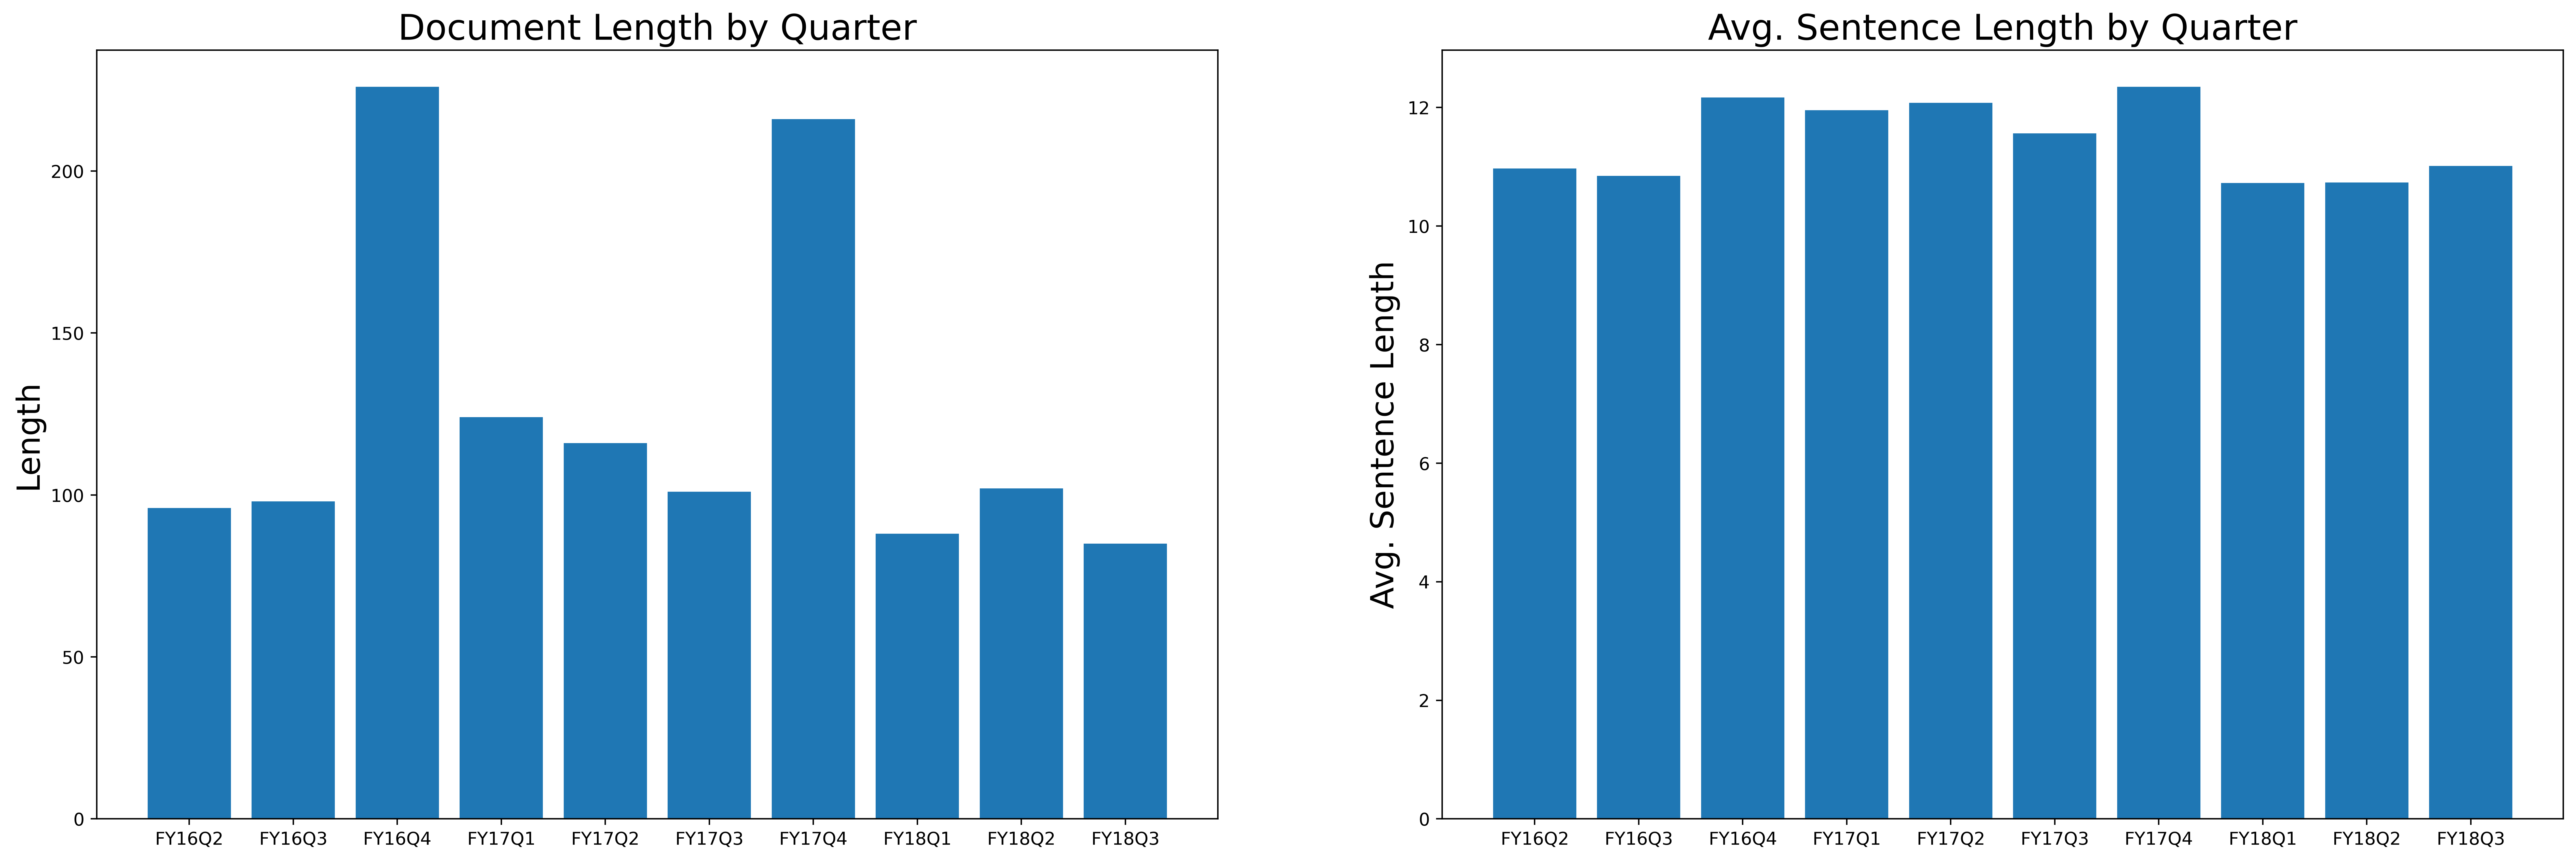

In [11]:
avg_sentence_len = []
document_length = []
quarters = df['quarter'].unique()
for quarter in quarters:
    temp_df = eda_df[eda_df['quarter'] == quarter]
    avg_sentence_len.append(sum(temp_df['word_count']/len(temp_df)))
    document_length.append(len(temp_df))
del temp_df

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8), dpi=500)
ax1.bar(quarters, document_length, color='tab:blue')
ax1.set_title("Document Length by Quarter", fontdict={'size': 20})
ax1.set_ylabel("Length", fontdict={'size': 18})
ax2.bar(quarters, avg_sentence_len, color='tab:blue')
ax2.set_title("Avg. Sentence Length by Quarter", fontdict={'size': 20})
ax2.set_ylabel("Avg. Sentence Length", fontdict={'size': 18})
plt.show()

In [12]:
# Recording actual results for the quarters from the performance data
result_df = pd.DataFrame()
quarters = df['quarter'].unique()
result_df['quarter'] = quarters

performance = performance_df['performance'].unique()
result_df['performance'] = performance
result_df['label'] = ['Sell' if x<-1 else 'Hold' if -1<=x<1 else 'Buy' for x in result_df['performance']]

# Creating a dataframe to record final outputs
final_df = pd.DataFrame()
final_df['quarter'] = quarters
final_df['actual'] = result_df['label']

In [13]:
# Recording keywords present in the text in a new column
keywords = ['azure', 'cloud', 'office', 'surface', 'xbox', 'phone']
keywords = '|'.join(keywords)
norm = len(keywords)
df['keywords'] = df.text_clean.str.findall(pat = keywords)

In [14]:
# Generating EPS based recommendations based on difference of actual and estimated EPS figures
fin_data.columns = fin_data.iloc[7]
eps_estimate = fin_data.loc[8, ['Q2 Dec-15', 'Q3 Mar-16', 'Q4 Jun-16', 'Q1 Sep-16', 'Q2 Dec-16', 'Q3 Mar-17', 'Q4 Jun-17', 'Q1 Sep-17', 'Q2 Dec-17', 'Q3 Mar-18']]
estimates = []
for i in eps_estimate:
    estimates.append(i)
eps_df['pred'] = estimates
eps_df['diff'] = eps_df['eps'] - eps_df['pred']
eps_df['recommendation'] = ['Sell' if x<-0.2 else 'Hold' if -0.2<=x<-0.05 else 'Buy' for x in eps_df['diff']]

final_df['EPS_pred'] = eps_df['recommendation']

# Classifier 1 - BERT1

In [15]:
classification = classify()
results = classification.bert_classifier(df['text_clean'].to_list())

2022-09-01 00:09:10.663388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [16]:
# Recording classification results for the BERT1 model
class1_df = df.copy()
labels = [d['label'] for d in results]
scores = [d['score'] for d in results]
class1_df['label'], class1_df['score'] = labels, scores

In [17]:
# Creating a sentiment score based on the classification results
rank_dict = {'Positive':1, 'Neutral':0.1, 'Negative':-1}
norm = len(keywords)
temp = [rank_dict[label] for label in class1_df['label']]
rank = []
for i in range(len(df['keywords'])):
    rank.append(temp[i]*(1+(len(class1_df['keywords'][i])/norm))*class1_df['score'][i])
class1_df['sentiment_score'] = rank

In [18]:
bert1_recs = []
# Collecting Data for Visualizations
bert1_stack_data = pd.DataFrame(columns = ['quarter','positive','neutral','negative'])
bert1_value_counts = []
quarters = df['quarter'].unique()
for quarter in quarters:
    temp_df = class1_df[class1_df['quarter'] == quarter]
    x = pd.value_counts(temp_df['label'], normalize=True, sort=False).to_list()
    bert1_value_counts.append(x)
    final_value =  (x[0]*1+x[1]*0.01+x[2]*-1)
    bert1_recs.append('Sell' if final_value<-0.02 else 'Hold' if -0.02<=final_value<0.02 else 'Buy')

# Recording the proportions of values for positive, neutral, and negative results for visualizations
bert1_stack_data['quarter'] = quarters
for quarter in range(len(quarters)):
    bert1_stack_data['positive'][quarter] = bert1_value_counts[quarter][0]
    bert1_stack_data['neutral'][quarter] = bert1_value_counts[quarter][1]
    bert1_stack_data['negative'][quarter] = bert1_value_counts[quarter][2]

In [19]:
# Recording the results in the dataframe for final outputs
final_df['BERT1_pred'] = bert1_recs

In [20]:
def predict(w, eps, classification):
    pred = []
    for i in range(len(eps)):
        pred.append(w*eps[i]+(1-w)*classification[i])
    pred
    return pred

# Generating a recommendation based on BERT1 classification results and EPS recommendation
recommendation_df = pd.DataFrame()
recommendation_df['bert1'] = bert1_recs
recommendation_df['eps'] = eps_df['recommendation']
recommendation_df['actual'] = result_df['label']

recommendation_df.replace(to_replace = ['Buy', 'Hold' ,'Sell'], value = [1,0,-1], inplace=True)
recommendation = predict(w=0.5, eps = recommendation_df['eps'], classification=recommendation_df['bert1'])
recommendation_label = ['Sell' if x<-0.25 else 'Hold' if -0.25<=x<0.25 else 'Buy' for x in recommendation]

### Visulation of Sentiment Analysis

In [21]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

quarters = df["quarter"].unique()

fig = make_subplots(
    rows=len(quarters), cols=1,
    subplot_titles=(quarters))

for i, quarter in enumerate(quarters):
    temp_df = class1_df[class1_df["quarter"] == quarter]
    temp_df.reset_index(inplace=True)

    fig.update_layout(
        title={
                'text': "Sentiment",
                'y':0.985,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font':dict(size=20),
                },
                height=2800,width=1300,
            )
    color_list = ['red' if x<-0.2 else 'orange' if -0.2<=x<0.2 else 'green' for x in temp_df['sentiment_score']]
    fig.add_trace(
        go.Scatter(x=temp_df.index+1, y=temp_df.sentiment_score, marker_color=color_list, mode='markers', customdata=temp_df, hovertemplate= "<br>".join([
        "Text: %{customdata[5]}",
        "Keywords: %{customdata[6]}",
        "Sentiment: %{customdata[7]}",])
    ), row = i+1, col = 1
    )
    fig.add_scatter(x=temp_df.index+1, y=temp_df.sentiment_score, line={'color': 'grey'}, opacity=0.5, showlegend=False, row=i+1, col=1)
    
    fig.add_trace(
        go.Scatter(x=temp_df.index+1, y=np.repeat(0, len(temp_df)), mode='lines', line={'dash': 'dot', 'color': 'black'}, showlegend=False, hovertemplate=None, hoverinfo='skip'),
        row = i+1, col = 1
    )
    fig.update_traces(showlegend=False)
    recommendation = recommendation_label[i]
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.995,
                   y=-0.4,
                   text='Recommendation: ' + recommendation, 
                   showarrow=False,
                   row=i+1, col=1)
    fig.update_annotations(font_size=15)
    fig.update_xaxes(range=[0, len(temp_df)+1], showline=True, linewidth=1, linecolor='black', title_text="Sentence", mirror=True, row = i+1, col = 1)
    fig.update_yaxes(range=[-1.2, 1.2], showline=True, linewidth=1, linecolor='black', title_text="Score", mirror=True, dtick=1, row = i+1, col = 1)
fig.layout.template = 'ggplot2'
fig.show()

# Classifier 2 - BERT2

In [22]:
import pandas as pd
classification = classify()
class2_df = pd.DataFrame()
quarters = df['quarter'].unique()
for quarter in quarters:
    temp_df = df[df["quarter"] == quarter]
    predictions = classification.bert_classifier_2(temp_df['text_clean'].to_list())
    # Recording classification results for the BERT2 model
    positive = predictions[:, 0].tolist()
    neutral = predictions[:, 2].tolist()
    negative = predictions[:, 1].tolist()

    # Creating a sentiment score based on the classification results
    rank = []
    for i in range(len(temp_df['keywords'])):
        rank.append((positive[i]*(1+len(temp_df.iloc[i]['keywords'])/norm)) + (neutral[i]*(0.1+len(temp_df.iloc[i]['keywords'])/norm)) + (negative[i]*(-1-len(temp_df.iloc[i]['keywords'])/norm)))
    temp_df['sentiment_score'] = rank
    class2_df = pd.concat([class2_df, temp_df])
del temp_df
class2_df['label'] = ['Negative' if x<-0.2 else 'Neutral' if -0.2<=x<0.2 else 'Positive' for x in class2_df['sentiment_score']]

/var/folders/9d/5qqf7p4n7pq77gtd5j9cmrp00000gn/T/ipykernel_19552/1940109899.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9d/5qqf7p4n7pq77gtd5j9cmrp00000gn/T/ipykernel_19552/1940109899.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9d/5qqf7p4n7pq77gtd5j9cmrp00000gn/T/ipykernel_19552/1940109899.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [23]:
bert2_recs= []
# Collecting Data for Visualizations
bert2_stack_data = pd.DataFrame(columns = ['quarter','positive','neutral','negative'])
bert2_value_counts = []
quarters = df['quarter'].unique()
for quarter in quarters:
    temp_df = class2_df[class2_df['quarter'] == quarter]
    x = pd.value_counts(temp_df['label'], normalize=True, sort=False).to_list()
    bert2_value_counts.append(x)
    final_value =  (x[0]*1+x[1]*0.01+x[2]*-1)
    bert2_recs.append('Sell' if final_value<-0.02 else 'Hold' if -0.02<=final_value<0.02 else 'Buy')

# Recording the proportions of values for positive, neutral, and negative results for visualizations
bert2_stack_data['quarter'] = quarters
for quarter in range(len(quarters)):
    bert2_stack_data['positive'][quarter] = bert2_value_counts[quarter][0]
    bert2_stack_data['neutral'][quarter] = bert2_value_counts[quarter][1]
    bert2_stack_data['negative'][quarter] = bert2_value_counts[quarter][2]

In [24]:
# Recording the results in the dataframe for final outputs
final_df['BERT2_pred'] = bert2_recs

In [25]:
recommendation_df = pd.DataFrame()
recommendation_df['bert2'] = bert2_recs
recommendation_df['eps'] = eps_df['recommendation']
recommendation_df['actual'] = result_df['label']
recommendation_df.replace(to_replace = ['Buy', 'Hold' ,'Sell'], value = [1,0,-1], inplace=True)

In [26]:
def predict(w, eps, classification):
    pred = []
    for i in range(len(eps)):
        pred.append(w*eps[i]+(1-w)*classification[i])
    pred
    return pred

# Generating a recommendation based on BERT2 classification results and EPS recommendation
recommendation_df = pd.DataFrame()
recommendation_df['bert2'] = bert2_recs
recommendation_df['eps'] = eps_df['recommendation']
recommendation_df['actual'] = result_df['label']
recommendation_df.replace(to_replace = ['Buy', 'Hold' ,'Sell'], value = [1,0,-1], inplace=True)

recommendation = predict(w=0, eps = recommendation_df['eps'], classification=recommendation_df['bert2'])
recommendation_label = ['Sell' if x<-0.25 else 'Hold' if -0.25<=x<0.25 else 'Buy' for x in recommendation]

### Visulation of Sentiment Analysis

In [27]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

quarters = df["quarter"].unique()

fig = make_subplots(
    rows=len(quarters), cols=1,
    subplot_titles=(quarters))

for i, quarter in enumerate(quarters):
    temp_df = class2_df[class2_df["quarter"] == quarter]
    temp_df.reset_index(inplace=True)

    fig.update_layout(
        title={
                'text': "Sentiment",
                'y':0.985,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font':dict(size=20),
                },
                height=2400,width=1300,
            )
    color_list = ['red' if x<-0.2 else 'orange' if -0.2<=x<0.2 else 'green' for x in temp_df['sentiment_score']]
    fig.add_trace(
        go.Scatter(x=temp_df.index+1, y=temp_df.sentiment_score, marker_color=color_list, mode='markers', customdata=temp_df, hovertemplate= "<br>".join([
        "Text: %{customdata[5]}",
        "Keywords: %{customdata[6]}",
        "Sentiment: %{customdata[8]}",])
    ), row = i+1, col = 1
    )
    fig.add_scatter(x=temp_df.index+1, y=temp_df.sentiment_score, line={'color': 'grey'}, opacity=0.5, showlegend=False, row=i+1, col=1)
    fig.add_trace(
        go.Scatter(x=temp_df.index+1, y=np.repeat(0, len(temp_df)), mode='lines', line={'dash': 'dot', 'color': 'black'}, showlegend=False, hovertemplate=None, hoverinfo='skip'),
        row = i+1, col = 1
    )
    fig.update_traces(showlegend=False)
    recommendation = recommendation_label[i]
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.995,
                   y=-0.4,
                   text='Recommendation:' + recommendation, 
                   showarrow=False,
                   row=i+1, col=1)
    fig.update_annotations(font_size=15)
    fig.update_xaxes(range=[0, len(temp_df)+1], showline=True, linewidth=1, linecolor='black', title_text="Sentence", mirror=True, row = i+1, col = 1)
    fig.update_yaxes(range=[-1.2, 1.2], showline=True, linewidth=1, linecolor='black', title_text="Score", mirror=True, dtick=1, row = i+1, col = 1)
fig.layout.template = 'ggplot2'
fig.show()

# Classifier 3 - RoBERTa

In [28]:
import pandas as pd
from classifiers import classify

classification = classify()
class3_df = pd.DataFrame()
quarters = df['quarter'].unique()
for quarter in quarters:
    temp_df = df[df["quarter"] == quarter]
    predictions = classification.roberta_classifier(temp_df['text_clean'].to_list())
    # Recording classification results for the RoBERTa model
    positive = predictions[:, 2].tolist()
    neutral = predictions[:, 1].tolist()
    negative = predictions[:, 0].tolist()

    # Creating a sentiment score based on the classification results
    rank = []
    for i in range(len(predictions)):
        rank.append((positive[i]*(1+len(temp_df.iloc[i]['keywords'])/norm)) + (neutral[i]*(0.1+len(temp_df.iloc[i]['keywords'])/norm)) + (negative[i]*(-1-len(temp_df.iloc[i]['keywords'])/norm)))
    temp_df['sentiment_score'] = rank
    class3_df = pd.concat([class3_df, temp_df])
del temp_df
class3_df['label'] = ['Negative' if x<-0.2 else 'Neutral' if -0.2<=x<0.2 else 'Positive' for x in class3_df['sentiment_score']]

/var/folders/9d/5qqf7p4n7pq77gtd5j9cmrp00000gn/T/ipykernel_19552/1337163118.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9d/5qqf7p4n7pq77gtd5j9cmrp00000gn/T/ipykernel_19552/1337163118.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/9d/5qqf7p4n7pq77gtd5j9cmrp00000gn/T/ipykernel_19552/1337163118.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [29]:
roberta_recs = []
# Collecting Data for Visualizations
roberta_stack_data = pd.DataFrame(columns = ['quarter','positive','neutral','negative'])
roberta_value_counts = []
quarters = df['quarter'].unique()
for quarter in quarters:
    temp_df = class3_df[class3_df['quarter'] == quarter]
    x = pd.value_counts(temp_df['label'], normalize=True, sort=False).to_list()
    roberta_value_counts.append(x)
    final_value =  (x[0]*1+x[1]*0.01+x[2]*-1)
    roberta_recs.append('Sell' if final_value<0.06 else 'Hold' if 0.06<=final_value<0.075 else 'Buy')

# Recording the proportions of values for positive, neutral, and negative results for visualizations
roberta_stack_data['quarter'] = quarters
for quarter in range(len(quarters)):
    roberta_stack_data['positive'][quarter] = roberta_value_counts[quarter][0]
    roberta_stack_data['neutral'][quarter] = roberta_value_counts[quarter][1]
    roberta_stack_data['negative'][quarter] = roberta_value_counts[quarter][2]

In [30]:
# Recording the results in the dataframe for final outputs
final_df['Roberta_pred'] = roberta_recs

In [31]:
recommendation_df = pd.DataFrame()
recommendation_df['roberta'] = roberta_recs
recommendation_df['eps'] = eps_df['recommendation']
recommendation_df['actual'] = result_df['label']
recommendation_df.replace(to_replace = ['Buy', 'Hold' ,'Sell'], value = [1,0,-1], inplace=True)

In [32]:
def predict(w, eps, classification):
    pred = []
    for i in range(len(eps)):
        pred.append(w*eps[i]+(1-w)*classification[i])
    pred
    return pred


# Generating a recommendation based on RoBERTa classification results and EPS recommendation
recommendation_df = pd.DataFrame()
recommendation_df['roberta'] = roberta_recs
recommendation_df['eps'] = eps_df['recommendation']
recommendation_df['actual'] = result_df['label']
recommendation_df.replace(to_replace = ['Buy', 'Hold' ,'Sell'], value = [1,0,-1], inplace=True)

recommendation = predict(w=0, eps = recommendation_df['eps'], classification=recommendation_df['roberta'])
recommendation_label = ['Sell' if x<-0.25 else 'Hold' if -0.25<=x<0.25 else 'Buy' for x in recommendation]

### Visualization of Sentiment Analysis

In [33]:
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

quarters = df["quarter"].unique()

fig = make_subplots(
    rows=len(quarters), cols=1,
    subplot_titles=(quarters))

for i, quarter in enumerate(quarters):
    temp_df = class3_df[class3_df["quarter"] == quarter]
    temp_df.reset_index(inplace=True)

    fig.update_layout(
        title={
                'text': "Sentiment",
                'y':0.985,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font':dict(size=20),
                },
                height=2400,width=1300,
            )
    color_list = ['red' if x<-0.2 else 'orange' if -0.2<=x<0.2 else 'green' for x in temp_df['sentiment_score']]
    fig.add_trace(
        go.Scatter(x=temp_df.index+1, y=temp_df.sentiment_score, marker_color=color_list, mode='markers', customdata=temp_df, hovertemplate= "<br>".join([
        "Text: %{customdata[5]}",
        "Keywords: %{customdata[6]}",
        "Sentiment: %{customdata[8]}",])    
        ), row = i+1, col = 1
    )
    fig.add_scatter(x=temp_df.index+1, y=temp_df.sentiment_score, line={'color': 'grey'}, opacity=0.5, showlegend=False, row=i+1, col=1)
    fig.add_trace(
        go.Scatter(x=temp_df.index+1, y=np.repeat(0, len(temp_df)), mode='lines', line={'dash': 'dot', 'color': 'black'}, showlegend=False, hovertemplate=None, hoverinfo='skip'),
        row = i+1, col = 1
    )
    fig.update_traces(showlegend=False)
    recommendation = recommendation_label[i]
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.995,
                   y=-0.4,
                   text='Recommendation:' + recommendation, 
                   showarrow=False,
                   row=i+1, col=1)
    fig.update_annotations(font_size=15)
    fig.update_xaxes(range=[0, len(temp_df)+1], showline=True, linewidth=1, linecolor='black', title_text="Sentence", mirror=True, row = i+1, col = 1)
    fig.update_yaxes(range=[-1.2, 1.2], showline=True, linewidth=1, linecolor='black', title_text="Score", mirror=True, dtick=1, row = i+1, col = 1)
fig.layout.template = 'ggplot2'
fig.show()

# Visuzualisations

(0.0, 1.1)

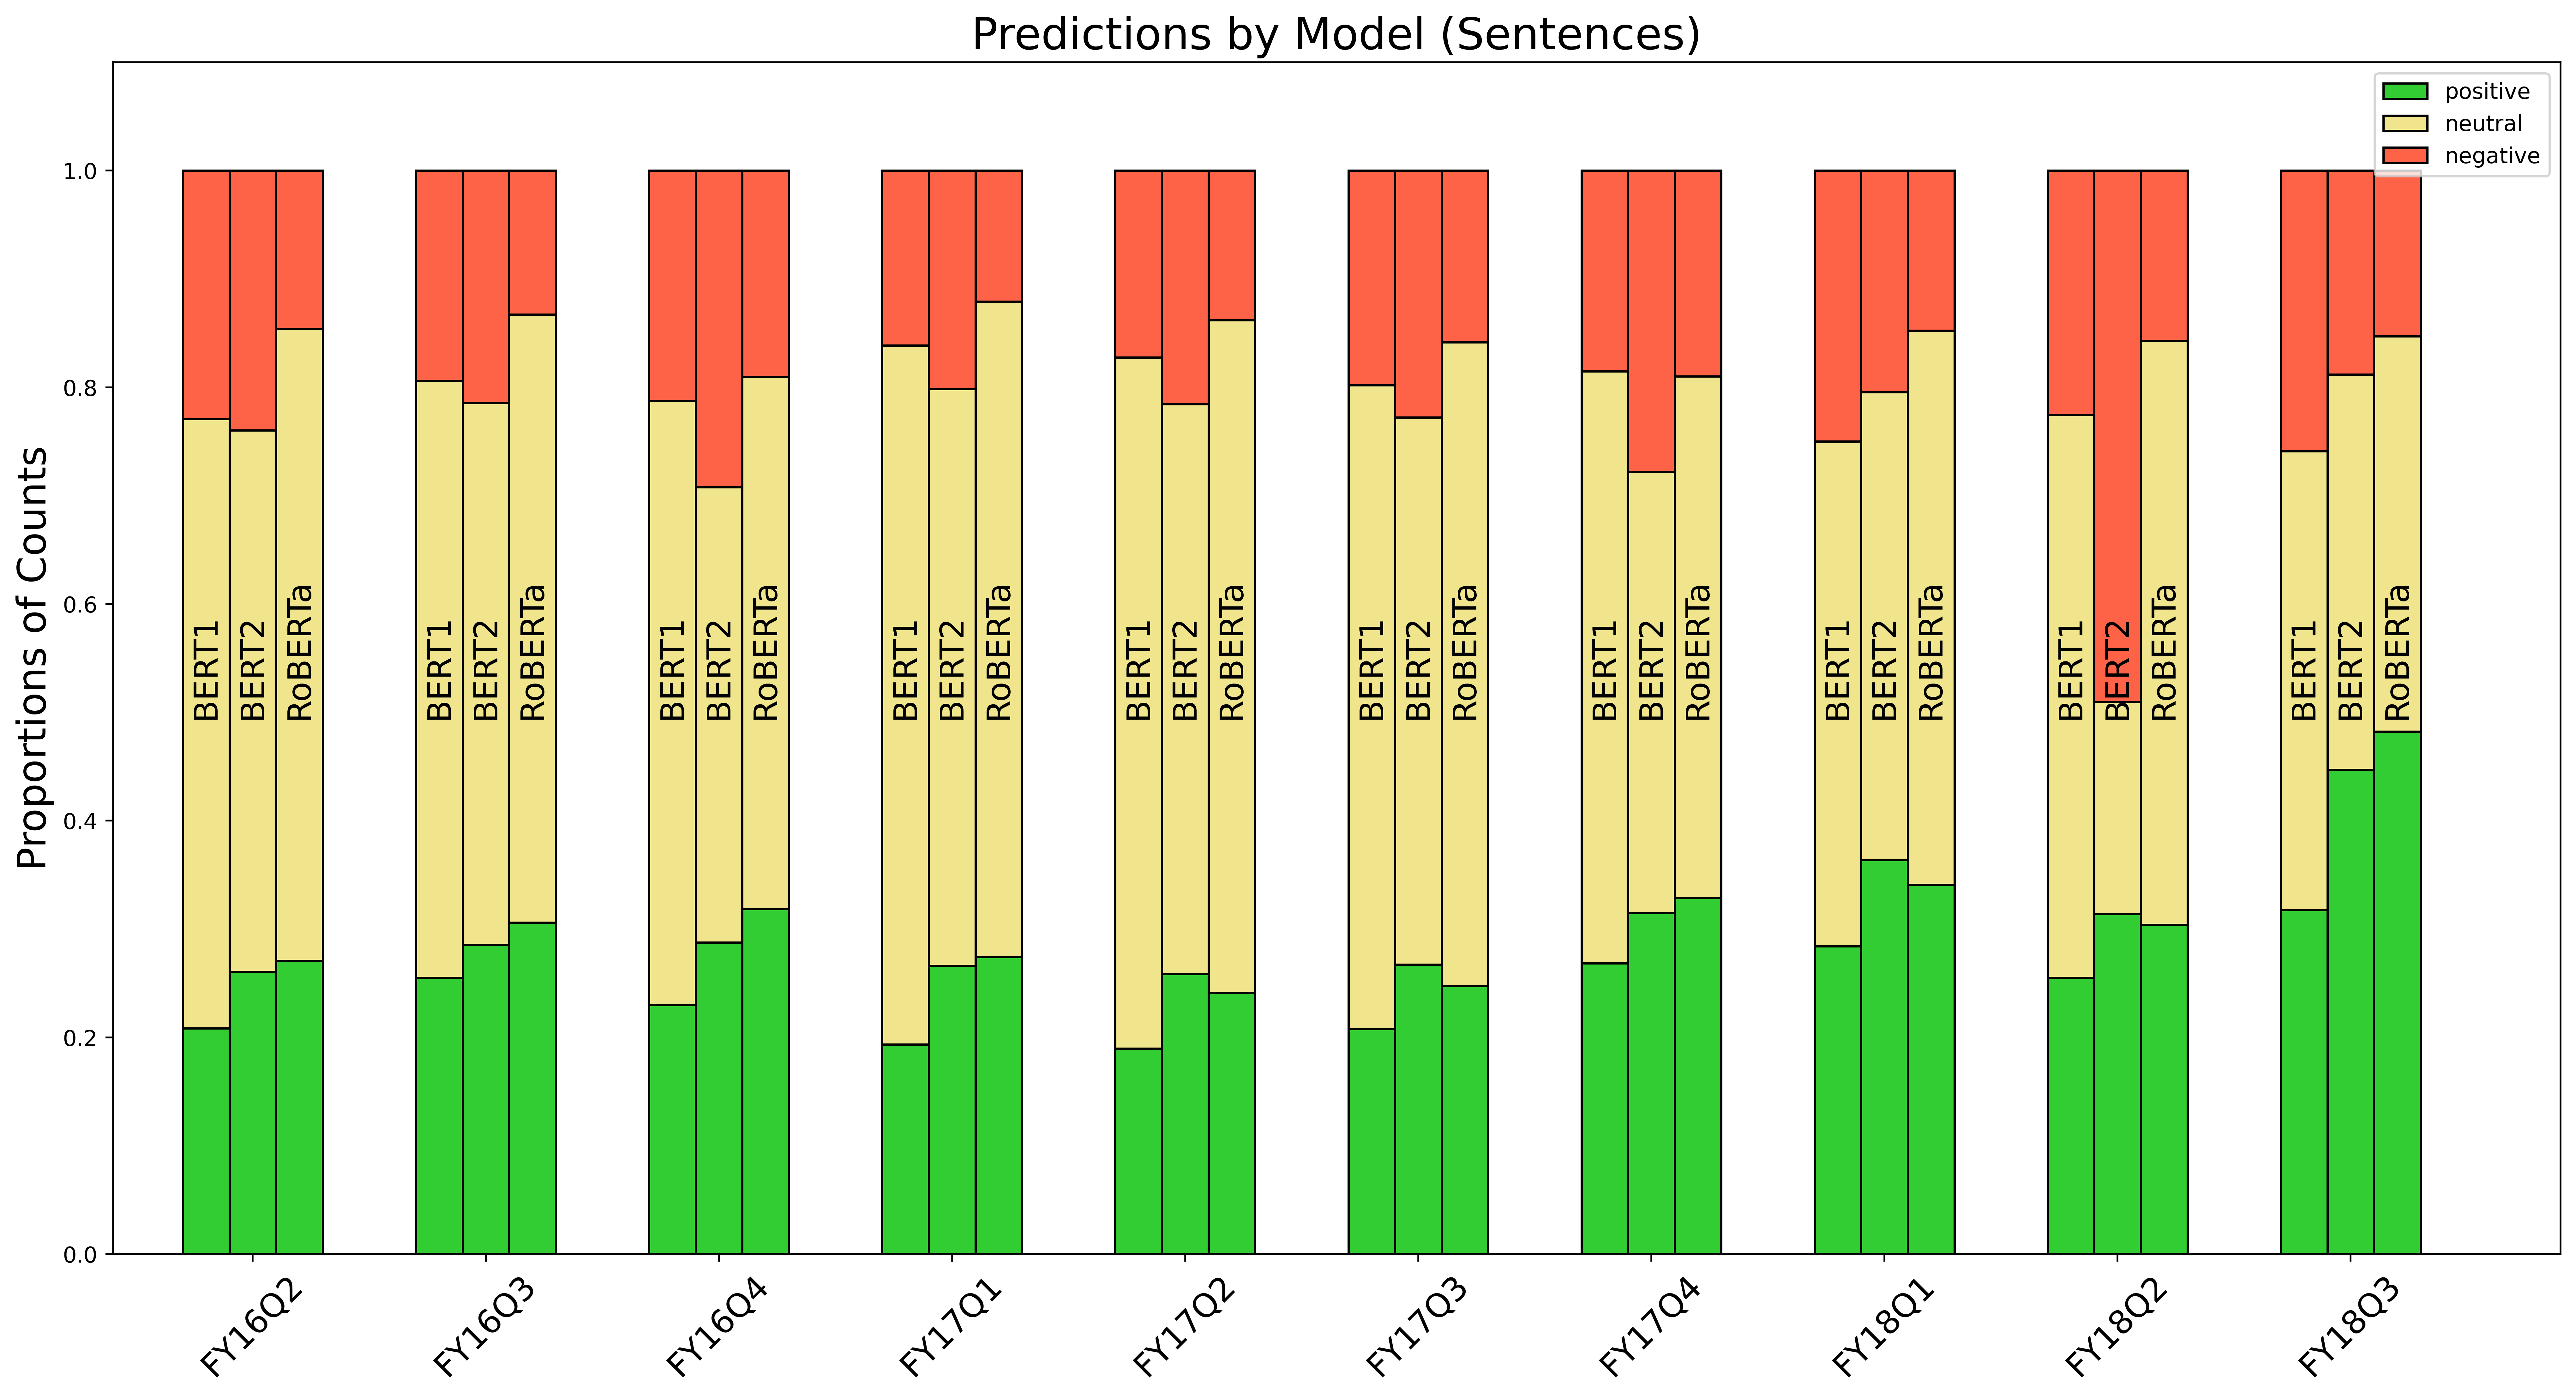

In [34]:
fig, ax = plt.subplots(figsize = (20,10), dpi=500)
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('', ['green','orange','red'])
cmap1 = LinearSegmentedColormap.from_list('', ['limegreen','khaki','tomato'])
b1 = bert1_stack_data.plot(kind="bar", stacked=True, width=0.2, 
                  ax=ax, position=1, edgecolor='k', cmap = cmap1)
b2 = bert2_stack_data.plot(kind="bar", stacked=True, width=0.2, 
                    ax=ax, position=0, edgecolor='k', cmap = cmap1, legend = None)
rob = roberta_stack_data.plot(kind="bar", stacked=True, width=0.2, 
                  ax=ax, position=-1, edgecolor='k', cmap = cmap1, legend = None)


for i in range(len(bert1_stack_data)):
    # ax.annotate('BERT1', xy = (i-0.2, 1.01), rotation = 35)
    # ax.annotate('BERT2', xy=(i,1.01), rotation = 35)
    # ax.annotate('RoBERTa', xy=(i+0.2,1.01), rotation = 35)
    ax.annotate('BERT1', xy = (i-0.17, 0.5), rotation = 90, fontsize = 15)
    ax.annotate('BERT2', xy=(i+0.03,0.5), rotation = 90, fontsize = 15)
    ax.annotate('RoBERTa', xy=(i+0.23,0.5), rotation = 90, fontsize = 15)

ax.set_title("Predictions by Model (Sentences)", fontsize = 20)
ax.set_ylabel("Proportions of Counts", fontsize = 18)

ax.set_xticks([0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1])
ax.set_xticklabels(quarters, rotation = 45, fontsize = 15)
ax.set_xlim(left = -0.5, right=len(bert1_stack_data))
ax.set_ylim(top = 1.1)

# Predictions


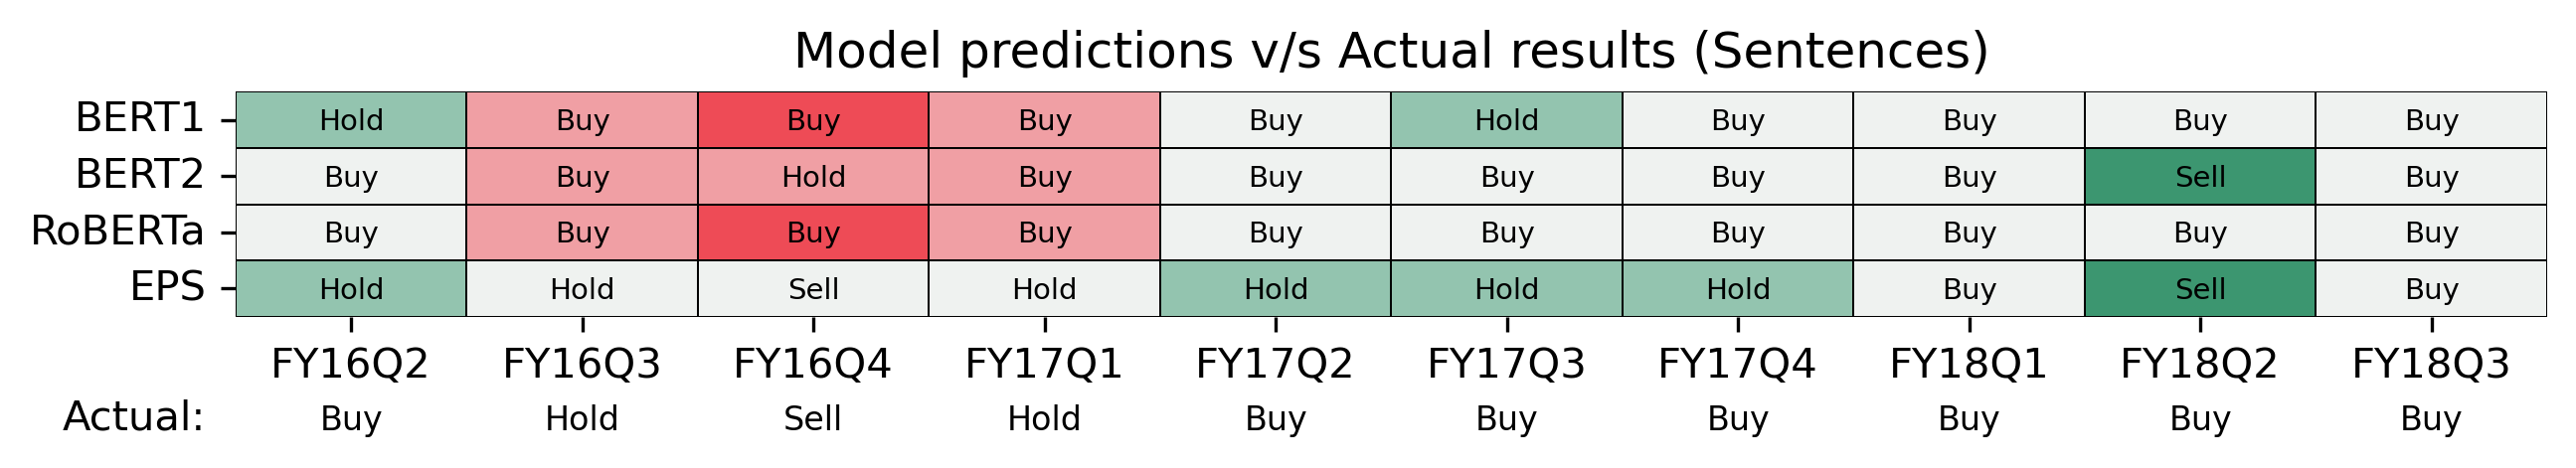

In [35]:
pred_df = final_df.replace(to_replace = ['Buy', 'Hold' ,'Sell'], value = [1,0,-1])
heatmap_df = pd.DataFrame()
heatmap_df['Bert1'] = (pred_df['actual'] - pred_df['BERT1_pred'])#.astype(int)
heatmap_df['Bert2'] = (pred_df['actual'] - pred_df['BERT2_pred'])#.astype(int)
heatmap_df['Roberta'] = (pred_df['actual'] - pred_df['Roberta_pred'])#.astype(int)
heatmap_df['EPS'] = (pred_df['actual'] - pred_df['EPS_pred'])
heatmap_df = heatmap_df.T
heatmap_df.columns = quarters
heatmap_df


import seaborn as sns
plt.figure(figsize=(10,1), edgecolor='k', dpi=300)
cmap = sns.diverging_palette(10, 150, s=80, l=56, n=5)
sns.heatmap(heatmap_df, yticklabels = ['BERT1', 'BERT2', 'RoBERTa', 'EPS'], cmap = cmap, cbar = False, linewidths=0.1, linecolor='black').set_title('Model predictions v/s Actual results (Sentences)')
plt.text(-0.75, 6, "Actual:", horizontalalignment='left', size='medium', color='black')
for i in range(len(quarters)):
    plt.text(i+0.5, 6, final_df['actual'][i], horizontalalignment='center', fontsize=8, color='black')
for i in range(len(quarters)):
    plt.text(i+0.5, 0.67, final_df['BERT1_pred'][i], horizontalalignment='center', fontsize=7, color='black')
for i in range(len(quarters)):
    plt.text(i+0.5, 1.67, final_df['BERT2_pred'][i], horizontalalignment='center', fontsize=7, color='black')
for i in range(len(quarters)):
    plt.text(i+0.5, 2.67, final_df['Roberta_pred'][i], horizontalalignment='center', fontsize=7, color='black')
for i in range(len(quarters)):
    plt.text(i+0.5, 3.67, final_df['EPS_pred'][i], horizontalalignment='center', fontsize=7, color='black')
plt.show()